In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from PIL import Image
import skimage

from skimage import measure

Using TensorFlow backend.


In [17]:
path = '/home/grads/n/narendra5/Desktop/Programs/LER_machine_learning/'
#path = r"C:\\Users\\narendra\\Documents\\LER\\"

model = load_model(path + 'models/' + 'Linenet_round_L1_epoch_4.h5')

#model = load_model(path + 'LER_machine_learning\\models\\' + 'Linenet_round_L1_epoch_4.h5')

In [18]:
sigma = 1.2
alpha = 0.6
Xi = 30
width = 20
space = 40
noise = 2
shift = math.floor(-25 + (width + space/2 + Xi + alpha*10 + sigma*10)%16) 

original_file = path + 'original_images2/oim_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '.tiff'
noisy_file = path + 'noisy_images2/nim_' + "{0:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '_' + str(noise) + '.tiff'

im = np.array(Image.open(original_file))
im = im/256

imnoisy = np.array(Image.open(noisy_file))
imnoisy = (imnoisy)/256
imnoisy = imnoisy.reshape(1,1024,64,1)

predict = model.predict(imnoisy)

imnoisy = imnoisy.reshape(1024,64)
predict = predict.reshape(1024,64,2)

PSNR noisy image =  10.2541418932
PSNR predicted image =  24.426863844


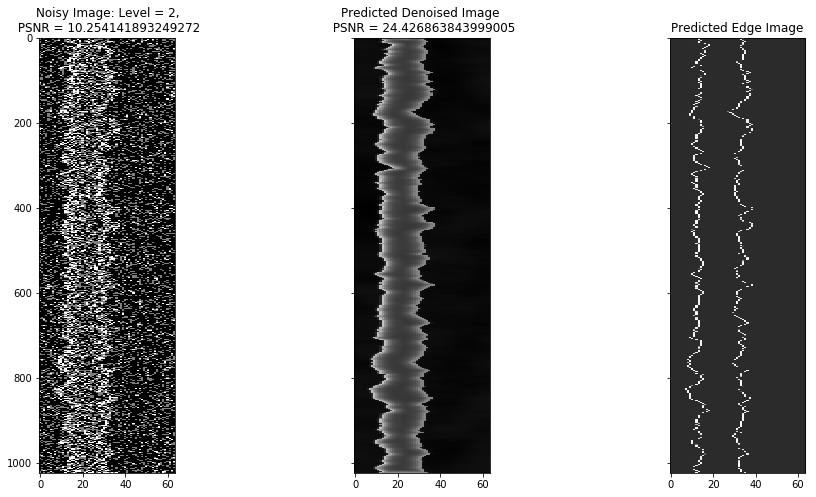

In [19]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8), sharex=True,
                       sharey=True, subplot_kw={'adjustable': 'box-forced'})

psnr_noisy = measure.compare_psnr(im,imnoisy.astype(float))
psnr_predict = measure.compare_psnr(im,predict[:,:,0].astype(float))
print('PSNR noisy image = ', psnr_noisy)
print('PSNR predicted image = ', psnr_predict)

ax[0].imshow(imnoisy,cmap = 'gray',aspect= 0.2)
ax[0].set_title('Noisy Image: Level = {},\n PSNR = {}'.format(noise, psnr_noisy))


ax[1].imshow(predict[:,:,0], cmap = 'gray',aspect= 0.2)
ax[1].set_title('Predicted Denoised Image \n PSNR = {}'.format(psnr_predict))

ax[2].imshow(predict[:,:,1], cmap = 'gray',aspect= 0.2)
ax[2].set_title('Predicted Edge Image')

plt.show()


(array([ 1, 13, 25, 32, 34, 38, 61]),)


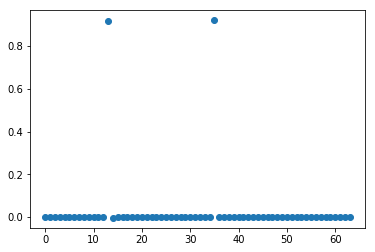

In [20]:
from scipy.signal import argrelextrema    # To get maxima
print(argrelextrema(predict[10,:,1], np.greater))
plt.plot(predict[8,:,1], 'o')           # plot one row of edge image
plt.show()

In [21]:
predict[:,:,1] = predict[:,:,1] > 0.1
leftline_pred = np.argmax(predict[:,:,1],axis = 1)
rightline_pred = np.argmax(np.fliplr(predict[:,:,1]),axis = 1)
rightline_pred = 63 - rightline_pred

Original leftline sigma = 1.0012804416786456, rightline sigma = 1.1526048267544757
Predicted leftline sigma = 3.038695796230483, rightline sigma = 4.342314750616008
2210.0
3859.0


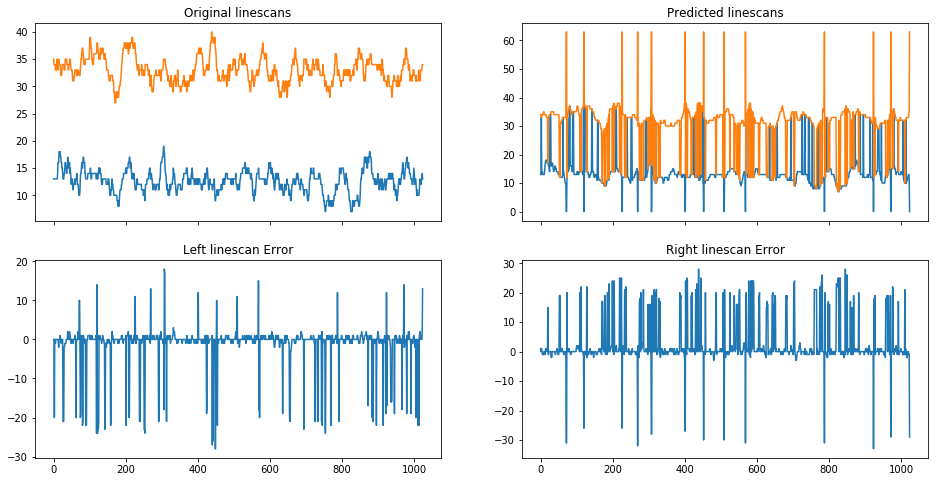

In [22]:
linescan_file = path + 'linescans/linescan_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '.txt'
linescan = []
with open(linescan_file,'r') as f:
    for i, line in enumerate(f):
        if i < 3000:
            a, b = line.split(',')
            linescan.append(float(b))


linescan = linescan[:2048]

leftline = np.array(linescan[:1024]) 
rightline = linescan[1024:]
rightline.reverse()
rightline = np.array(rightline)

leftline = leftline + shift
rightline = rightline + shift


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), sharex=True,
                       sharey=False, subplot_kw={'adjustable': 'box-forced'})

print('Original leftline sigma = {}, rightline sigma = {}'.format(leftline.round().std()/2, \
                                                                  rightline.round().std()/2))

print('Predicted leftline sigma = {}, rightline sigma = {}'.format(leftline_pred.std()/2, \
                                                                  rightline_pred.std()/2))

print(np.abs(leftline.round() - leftline_pred).sum())
print(np.abs(rightline.round() - rightline_pred).sum())

ax[0,0].plot(leftline.round())
ax[0,0].plot(rightline.round())
ax[0,0].set_title('Original linescans')

ax[0,1].plot(leftline_pred)
ax[0,1].plot(rightline_pred)
ax[0,1].set_title('Predicted linescans')

ax[1,0].plot(leftline.round() - leftline_pred)
ax[1,0].set_title('Left linescan Error')

ax[1,1].plot(rightline.round() - rightline_pred)
ax[1,1].set_title('Right linescan Error')
plt.show()

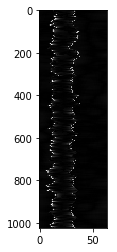

In [23]:
plt.imshow(np.abs(im - predict[:,:,0]), cmap = 'gray',aspect= 0.2)
plt.show()